In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
%matplotlib inline

/home/alexattia/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.read_csv('./train.csv')

In [3]:
df_test = pd.read_csv('./test.csv')

In [3]:
target = pd.read_csv('./challenge_output_data_training_file_nba_challenge.csv', sep=';')

**Data**   
Play-by-play datasets from the last 15 NBA seasons.  
Each game is described by 11 variables for every second of the game from the fist halft (1440 seconds, **1440x11 = 15840 columns**). These variables such as : "offensive rebound", "defensive rebound", "offensive foul", "defensive foul", "assist", "lost ball",  "steals", "bad pass","block", "miss" difference between the invited and home team. The scores/key indicators - represent the current score/key indicators differences.

The training set : 12576 NBA games.  
The test set : 4192 games.

In [4]:
print(df.shape)
print(target.shape)
df.head()

(12576, 15841)
(12576, 2)


,ID,score_1,offensive rebound_1,defensive rebound_1,offensive foul_1,defensive foul_1,assist_1,lost ball_1,steals_1,bad pass_1,...,offensive rebound_1440,defensive rebound_1440,offensive foul_1440,defensive foul_1440,assist_1440,lost ball_1440,steals_1440,bad pass_1440,block_1440,miss_1440
0,14186,-2,0,0,0,0,0,0,0,0,...,8,-4,2,0,-3,3,3,-2,1,9
1,13013,0,0,-1,0,0,0,0,0,0,...,1,5,0,0,1,0,0,1,-2,-1
2,7102,0,0,0,0,0,0,0,1,1,...,-1,-5,-5,0,0,5,5,-2,3,-5
3,7637,-2,0,0,0,0,0,0,0,0,...,2,8,1,0,-1,-1,2,2,-1,-1
4,12350,0,0,0,0,0,0,0,0,0,...,4,1,0,0,4,3,2,1,1,3


In [4]:
df_tot = pd.merge(df, target, on='ID')
# When the HT winner is the FT winner
same_mt_f = df_tot[((df_tot.score_1440 <= 0) & (df_tot.label == 0)) | ((df_tot.score_1440 >= 0) & (df_tot.label == 1))]
print('Probability that the half-time leader is the full-time winner %.3f' % (len(same_mt_f)/len(df_tot)))

Probability that the half-time leader is the full-time winner 0.743


In [71]:
diff_goals = 8
same_mt_f = df_tot[((df_tot.score_1440 <= -1*diff_goals) & (df_tot.label == 0)) | ((df_tot.score_1440 >= diff_goals) & (df_tot.label == 1))]
temp = df_tot[(df_tot.score_1440 <= -1*diff_goals) | (df_tot.score_1440 >= diff_goals)]
print('Probability that the %d pt margin half-time  leader is the full-time winner %.3f' % (diff_goals, len(same_mt_f)/len(temp)))
print('Over %.3f of data' % (len(temp)/len(df_tot)))

Probability that the 8 pt margin half-time  leader is the full-time winner 0.856
Over 0.463 of data


In [87]:
diff_goals = 8
diff_assists = 3
temp = df_tot[(np.abs(df_tot.score_1440) < diff_goals) ]
same_mt_f = temp[((temp.assist_1440 >= -1*diff_assists) & (temp.label == 0)) 
                   | ((temp.assist_1440 <= diff_assists) & (df_tot.label == 1))]
temp2 = temp[np.abs(temp.assist_1440 <= diff_assists) ]
#temp = df_tot[(np.abs(df_tot.score_1440) <= diff_goals) & (np.abs(df_tot.miss_1440) >= 5)]
print('Probability that the less than %d pt margin and more than %d assist margin half-time leader is the full-time winner %.3f' % (diff_goals, diff_assists, len(same_mt_f)/len(temp)))
print('Over %.3f of data' % (len(temp2)/len(df_tot)))

/home/alexattia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


Probability that the less than 8 pt margin and more than 3 assist margin half-time leader is the full-time winner 0.800
Over 0.455 of data


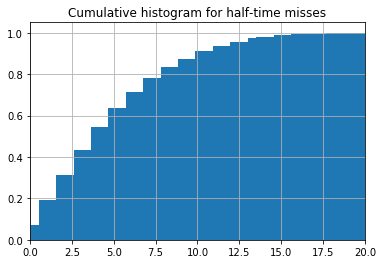

In [75]:
import matplotlib.pyplot as plt
f, ax = plt.subplots()
ax.hist(np.abs(df_tot.miss_1440.values), bins=50, normed=1,  cumulative=True)
_ = ax.set_xlim([0, 20])
_ = ax.grid()
_ = ax.set_title('Cumulative histogram for half-time misses')

In [18]:
np.sum(df_tot.score_1440.values <= 0)/len(df_tot)

0.5891380407124682

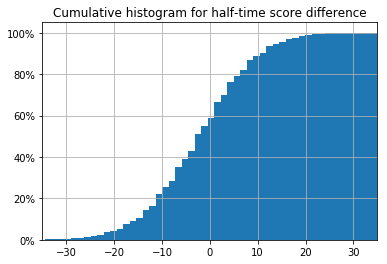

In [25]:
import matplotlib.pyplot as plt
f, ax = plt.subplots()
ax.hist(df_tot.score_1440.values, bins=100, normed=1,  cumulative=True)
ax.set_xlim([-35, 35])
ax.grid()
vals = ax.get_yticks()
ax.set_yticklabels(['{:1.0f}%'.format(x*100) for x in vals])
_ = ax.set_title('Cumulative histogram for half-time score difference')

In [7]:
print('Probability that the home team wins the game at FT %.3f' % (len(df_tot[df_tot.label == 0])/len(df_tot)))
print('Probability that the home team wins the game at HT %.3f' % (len(df_tot[df_tot.score_1440 <= 0])/len(df_tot)))

Probability that the home team wins the game at FT 0.564
Probability that the home team wins the game at HT 0.589


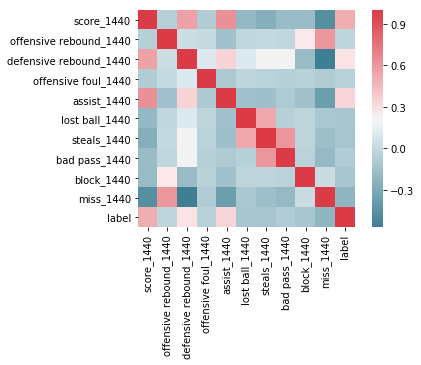

In [27]:
corr_ht = df_tot[[k for k in df_tot.columns if '1440' in k and 'defensive foul' not in k]+['label']].corr()
sns.heatmap(corr_ht, mask=np.zeros_like(corr_ht, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True)
#_ = plt.title('Features correlation at half-time and winner')

In [28]:
# Add new stats
ki = set([k.split('_')[0] for k in df_tot.columns if k not in ['label', 'ID']])
print('Current key indicators :', ki)

# Add total rebound
for k in range(1,1441):
    df_tot['total rebound_%d' % k] = df_tot['offensive rebound_%d' % k] + df_tot['defensive rebound_%d' % k]

# Re-sort columns
def sorter(x):
    if x not in ['label', 'ID']:
        return int(x.split('_')[1])
    else:
        return 0
    
df_tot = df_tot[sorted(df_tot.columns, key=sorter)]
print('Added total (off+def) rebound stats')

Current key indicators : {'block', 'bad pass', 'defensive rebound', 'lost ball', 'defensive foul', 'offensive rebound', 'offensive foul', 'miss', 'assist', 'score', 'steals'}
Added total (off+def) rebound stats


In [5]:
# Add new stats
ki = set([k.split('_')[0] for k in df_test.columns if k not in ['label', 'ID']])
print('Current key indicators :', ki)

# Add total rebound
for k in range(1,1441):
    df_test['total rebound_%d' % k] = df_test['offensive rebound_%d' % k] + df_test['defensive rebound_%d' % k]

# Re-sort columns
def sorter(x):
    if x not in ['label', 'ID']:
        return int(x.split('_')[1])
    else:
        return 0
    
df_test = df_test[sorted(df_test.columns, key=sorter)]
print('Added total (off+def) rebound stats')

Current key indicators : {'miss', 'block', 'defensive foul', 'bad pass', 'offensive rebound', 'assist', 'offensive foul', 'defensive rebound', 'score', 'steals', 'lost ball'}
Added total (off+def) rebound stats


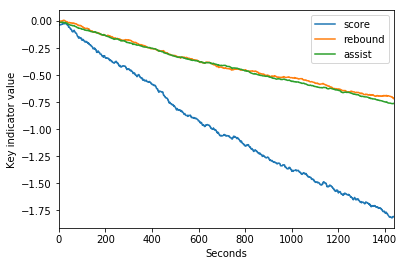

In [70]:
f, ax = plt.subplots()
df_tot[[k for k in df_tot.columns if 'score' in k]].mean().plot(ax=ax, label='score')
df_tot[[k for k in df_tot.columns if 'total rebound' in k]].mean().plot(ax=ax, label='rebound')
df_tot[[k for k in df_tot.columns if 'assist' in k]].mean().plot(ax=ax, label='assist')
#ax.set_title('Advantage key indicator for the home team')
ax.set_xlabel('Seconds')
ax.set_ylabel('Key indicator value')
p = ax.get_xticklabels()
ax.set_xticklabels([int(k.get_text().replace('assist_', ''))-1 if '1' in k.get_text() else '' for k in p])
_ = ax.legend()

['1', '201', '401', '601', '801', '1001', '1201', '1401', '']

In [54]:
df_tot[[k for k in df_tot.columns if 'score' in k]].mean()

score_1      -0.035782
score_2      -0.035782
score_3      -0.036419
score_4      -0.036021
score_5      -0.035226
score_6      -0.035226
score_7      -0.033874
score_8      -0.032284
score_9      -0.032522
score_10     -0.032522
score_11     -0.031807
score_12     -0.031250
score_13     -0.030137
score_14     -0.030137
score_15     -0.028785
score_16     -0.020118
score_17     -0.020118
score_18     -0.025684
score_19     -0.024094
score_20     -0.024571
score_21     -0.024571
score_22     -0.025048
score_23     -0.017891
score_24     -0.020515
score_25     -0.020515
score_26     -0.023139
score_27     -0.018289
score_28     -0.014631
score_29     -0.014631
score_30     -0.021151
                ...   
score_1411   -1.780852
score_1412   -1.779183
score_1413   -1.781886
score_1414   -1.784192
score_1415   -1.792462
score_1416   -1.794370
score_1417   -1.796279
score_1418   -1.800095
score_1419   -1.803515
score_1420   -1.807570
score_1421   -1.810194
score_1422   -1.812023
score_1423 

In [52]:
1441/9

160.11111111111111

https://github.com/Azure/lstms_for_predictive_maintenance/blob/master/Deep%20Learning%20Basics%20for%20Predictive%20Maintenance.ipynb  
Keras LSTM layers expect an input in the shape of a numpy array of 3 dimensions (samples, time steps, features) where samples is the number of training sequences, time steps is the look back window or sequence length and features is the number of features of each sequence at each time step.

In [8]:
df_tot.shape

(12576, 17282)

In [19]:
# Reformat with only 10 games
# For the reformating with reshape the dataframe
# from (10, 17282) to (10*1440, n_features)
df1 = df_tot#.sample(1000)

In [45]:
df_train, df_val = train_test_split(df1, test_size=0.15, random_state=42)

In [46]:
df_val_tot = pd.DataFrame()
for sec in range(1,1441):
    df_sec = df_val[['ID', 'label']+[k for k in df_val.columns if k not in ['label', 'ID'] and k.split('_')[1] == str(sec)]]
    df_sec.columns = [k.split('_')[0] if k not in ['ID', 'time_step', 'label'] else k for k in df_sec.columns]
    df_sec = df_sec.assign(time_step = sec)
    df_val_tot = pd.concat([df_val_tot, df_sec])
df_val_tot = df_val_tot.sort_values(['ID', 'time_step'])

In [20]:
df1_tot = pd.DataFrame()
for sec in range(1,1441):
    df_sec = df1[['ID', 'label']+[k for k in df1.columns if k not in ['label', 'ID'] and k.split('_')[1] == str(sec)]]
    df_sec.columns = [k.split('_')[0] if k not in ['ID', 'time_step', 'label'] else k for k in df_sec.columns]
    df_sec = df_sec.assign(time_step = sec)
    df1_tot = pd.concat([df1_tot, df_sec])
df1_tot = df1_tot.sort_values(['ID', 'time_step'])

In [6]:
df_test_tot = pd.DataFrame()
for sec in range(1,1441):
    df_sec = df_test[['ID']+[k for k in df_test.columns if k not in ['ID'] and k.split('_')[1] == str(sec)]]
    df_sec.columns = [k.split('_')[0] if k not in ['ID', 'time_step'] else k for k in df_sec.columns]
    df_sec = df_sec.assign(time_step = sec)
    df_test_tot = pd.concat([df_test_tot, df_sec])
df_test_tot = df_test_tot.sort_values(['ID', 'time_step'])

In [8]:
df1_tot.head()

,ID,label,score,offensive rebound,defensive rebound,offensive foul,defensive foul,assist,lost ball,steals,bad pass,block,miss,total rebound,time_step
2677,1,1,0,0,0,0,0,0,0,0,0,0,-1,0,1
2677,1,1,0,0,0,0,0,0,0,0,0,0,-1,0,2
2677,1,1,0,0,0,0,0,0,0,0,0,0,-1,0,3
2677,1,1,0,0,0,0,0,0,0,0,0,0,-1,0,4
2677,1,1,0,0,0,0,0,0,0,0,0,0,-1,0,5


In [9]:
print('Initial Shape', df1.shape)
print('Final Shape', df1_tot.shape)

Initial Shape (12576, 17282)
Final Shape (18109440, 15)


In [23]:
from sklearn.model_selection import train_test_split

In [27]:
df_train, df_val = train_test_split(df1_tot, test_size=0.15, random_state=42)

In [33]:
df_val.head(3)

,ID,label,score,offensive rebound,defensive rebound,offensive foul,defensive foul,assist,lost ball,steals,bad pass,block,miss,total rebound,time_step
8886,15931,0,6,1,5,0,0,5,1,-1,-2,-3,1,6,1042
8125,12977,0,4,0,1,0,0,2,0,-1,-1,1,-4,1,654
12226,1162,0,1,2,1,1,0,3,0,0,0,0,3,3,956


In [47]:
df_val = df_val_tot[df_val_tot.time_step < 1441]
X_val = []
y_val = df_val.groupby('ID').mean()['label'].values
y_val = y_val.reshape((len(y_val), 1))
for id_ in df_val.ID.unique():
    X_val.append(df_val[df_val.ID == id_][cols].values)
X_val = np.array(X_val)
X_val.shape, y_val.shape

((1887, 1440, 12), (1887, 1))

In [50]:
y_pred_val = my_model_.predict(X_val, batch_size=32)

In [54]:
Pred_val = pd.DataFrame(np.argmax(y_pred_val, axis=1), columns= ['label'])
Pred_val['ID'] = df_val.groupby('ID').ID.first().values
Pred_val['true'] = df_val.groupby('ID').label.first().values
#Pred[['ID', 'label']].to_csv('pred_v2.csv', index=False)

In [56]:
np.mean(Pred_val['label'] ==Pred_val['true'])

0.7503974562798092

In [7]:
cols = ['score', 'offensive rebound', 'defensive rebound',
       'offensive foul', 'defensive foul', 'assist', 'lost ball', 'steals',
       'bad pass', 'block', 'miss', 'total rebound']

In [12]:
df_X = df1_tot[df1_tot.time_step < 1441]
X_train = []
y_train = df_X.groupby('ID').mean()['label'].values
y_train = y_train.reshape((len(y_train), 1))
for id_ in df1_tot.ID.unique():
    X_train.append(df_X[df_X.ID == id_][cols].values)
X_train = np.array(X_train)
X_train.shape, y_train.shape

((12576, 1440, 12), (12576, 1))

In [8]:
df_X_test = df_test_tot[df_test_tot.time_step < 1441]
X_test = []
for id_ in df_X_test.ID.unique():
    X_test.append(df_X_test[df_X_test.ID == id_][cols].values)
X_test = np.array(X_test)
X_test.shape

(4192, 1440, 12)

In [13]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)

In [47]:
train_set = (X_train, y_train)

In [9]:
id_test = df_X_test.groupby('ID').ID.first().values

In [10]:
test_set = (X_test, id_test)

In [12]:
import pickle
with open('test_set.pkl', 'wb') as f:
    pickle.dump(test_set, f)

In [ ]:
import pickle
# with open('train_set.pkl', 'rb') as f:
#     (X_train, y_train) = pickle.load(f)
with open('test_set.pkl', 'rb') as f:
    X_test, id_test = pickle.load(f)

In [23]:
from keras.layers import BatchNormalization, Conv2D, Reshape, LSTM, Dropout, Dense, TimeDistributed, Lambda, MaxPool2D
from keras.optimizers import Adam
from keras.regularizers import l2

nb_timestep = 1440
nb_features = 12
num_classes = 2

my_model = Sequential()

my_model.add(BatchNormalization(input_shape = (nb_timestep,nb_features)))
print(my_model.output_shape)
my_model.add(Reshape([nb_timestep,nb_features,1]))
print(my_model.output_shape)
my_model.add(Conv2D(128, 5,activation="relu"))
print(my_model.output_shape)
my_model.add(Reshape([my_model.output_shape[1], my_model.output_shape[2]*my_model.output_shape[3]]))
print(my_model.output_shape)
my_model.add(LSTM(128, return_sequences=True))
print(my_model.output_shape)
my_model.add(Reshape([my_model.output_shape[1], 8, 16]))
print(my_model.output_shape)
my_model.add(Conv2D(64,5,activation="relu"))
print(my_model.output_shape)
my_model.add(Reshape([my_model.output_shape[1], my_model.output_shape[2]*my_model.output_shape[3]]))
print(my_model.output_shape)
my_model.add(LSTM(64, return_sequences=True))
print(my_model.output_shape)
my_model.add(Reshape([my_model.output_shape[1], 8, 8]))
print(my_model.output_shape)
my_model.add(Conv2D(64,5,activation="relu"))
print(my_model.output_shape)
my_model.add(Reshape([my_model.output_shape[1], my_model.output_shape[2]*my_model.output_shape[3]]))
print(my_model.output_shape)
my_model.add(LSTM(64, return_sequences=True))
print(my_model.output_shape)
my_model.add(Dropout(0.2))
print(my_model.output_shape)
my_model.add(TimeDistributed(Dense(2,activation="sigmoid", kernel_regularizer=l2(0.0001))))
print(my_model.output_shape)
my_model.add(Lambda(lambda x: x[:, -1, :], output_shape=[num_classes]))
print(my_model.output_shape)
my_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

(None, 1440, 12)
(None, 1440, 12, 1)
(None, 1436, 8, 128)
(None, 1436, 1024)
(None, 1436, 128)
(None, 1436, 8, 16)
(None, 1432, 4, 64)
(None, 1432, 256)
(None, 1432, 64)
(None, 1432, 8, 8)
(None, 1428, 4, 64)
(None, 1428, 256)
(None, 1428, 64)
(None, 1428, 64)
(None, 1428, 2)
(None, 2)


In [8]:
my_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.15, verbose=1)

In [49]:
from keras.models import load_model
my_model_ = load_model('my_model.h5')

In [16]:
y_pred = my_model_.predict(X_test, batch_size=32)

In [99]:
import public_accuracy
public_accuracy.score_function(y_train, np.round(y_))

0.7252703562340967

In [100]:
import numpy as np
            
def score_function(y_true, y_pred):
    score = 0
    length1 = y_true.shape[0]
    for i in range(length1):
        if y_pred[i] == y_true[i]:
            score += 1
    return float(score)/float(length1)

In [101]:
score_function(np.argmax(y_train, axis=1), np.argmax(y_, axis=1))

0.7252703562340967

In [17]:
Pred = pd.DataFrame(np.argmax(y_pred, axis=1), columns= ['label'])
Pred['ID'] = df_X_test.groupby('ID').ID.first().values
Pred[['ID', 'label']].to_csv('pred_v2.csv', index=False)

In [62]:
df_X_test.groupby('ID').ID.first().values

array([    0,     3,     6, ..., 18393, 18398, 18400])

In [59]:
df_X_test.ID.unique()

array([    0,     3,     6, ..., 18393, 18398, 18400])

In [19]:
Pred[['ID', 'label']]

,ID,label
0,0,0
1,3,0
2,6,0
3,12,0
4,13,1
5,24,0
6,26,0
7,27,0
8,42,0
9,48,1
